# Applied Statistics (ECS764P) - CW2

Task 1: Dataset Selection and Justification
Datasets:

Variable X: Daily Maximum Temperature (°C) in London.

Variable Y: Daily Total Solar Radiation (MJ/m
2
 ) in London.

Justification: I have selected these two one-dimensional datasets because they represent physical atmospheric processes that share a significant amount of underlying randomness. In a probabilistic framework, X and Y can be viewed as random variables governed by the same stochastic weather systems and seasonal cycles.

The dependency between these variables is rooted in the physics of solar heating: on days with high solar radiation (clear skies), the Earth's surface absorbs more energy, which in turn raises the ambient air temperature. Conversely, on randomly overcast days, both variables are expected to decrease. This "shared randomness" results in a strong positive dependency. By analyzing their empirical joint distribution, we can observe how these two processes co-vary over an annual cycle. This choice allows for a clear exploration of marginal distributions and joint behavior without the complexities of human behavioral factors found in economic data.


Task 2: Data Retrieval and Descriptive Statistics
In this task, we retrieve the variables justified in Task 1 for the year 2023. We use the Open-Meteo Historical Weather API, which provides a reliable, key-less endpoint suitable for a reproducible research environment.

1. Data Retrieval

We fetch n=365 joint observations of temperature (X) and solar radiation (Y).

In [17]:
# Install necessary libraries for the College environment
!pip install pandas requests matplotlib seaborn

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define API parameters for London
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 51.5074,
    "longitude": -0.1278,
    "start_date": "2023-01-01",
    "end_date": "2023-12-31",
    "daily": ["temperature_2m_max", "shortwave_radiation_sum"],
    "timezone": "Europe/London"
}

# Fetching the joint data
response = requests.get(url, params=params)
data = response.json()

# Creating the DataFrame for joint observations (X, Y)
df = pd.DataFrame({
    'Temp_Max': data['daily']['temperature_2m_max'],
    'Solar_Radiation': data['daily']['shortwave_radiation_sum']
}).dropna()

print(f"Data successfully retrieved. Sample size (n) = {len(df)}")

Data successfully retrieved. Sample size (n) = 365


In [18]:
# Presenting the descriptive statistics table
print("\n--- Basic Descriptive Statistics ---")
print(df.describe())


--- Basic Descriptive Statistics ---
         Temp_Max  Solar_Radiation
count  365.000000       365.000000
mean    15.516986        11.130630
std      6.261700         7.687327
min     -0.400000         0.330000
25%     11.000000         4.490000
50%     14.500000         9.540000
75%     20.500000        17.540000
max     31.400000        29.410000


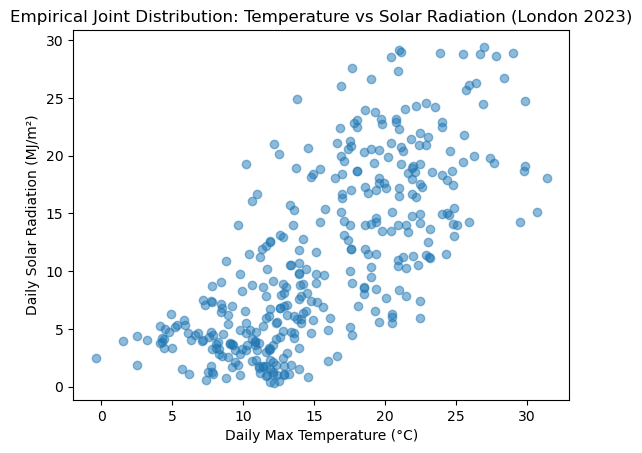

In [19]:
plt.scatter(df['Temp_Max'], df['Solar_Radiation'], alpha=0.5)
plt.xlabel('Daily Max Temperature (°C)')
plt.ylabel('Daily Solar Radiation (MJ/m²)')
plt.title('Empirical Joint Distribution: Temperature vs Solar Radiation (London 2023)')
plt.show()




# Task 3: Statistical Test for Linear Dependence

Characterization and hypothesis setup

Following the lecture material, linear dependence between two random variables is characterized by the Pearson correlation coefficient.

Null Hypothesis (H0):

ρ =0

(The variables are uncorrelated, i.e. there is no linear dependence.)

Alternative Hypothesis (H1 ):

ρ ≠ 0

(There is a statistically significant linear dependence between the variables.)


Significance Level (α):

We choose α = 0.05,corresponding to a 5% probability of rejecting the null hypothesis when it is in fact true.

Sample size (n): 365
Pearson Correlation (r): 0.7197
Observed t-statistic: 19.7510
P-value: 1.7287e-59
Critical t-value: 1.9665


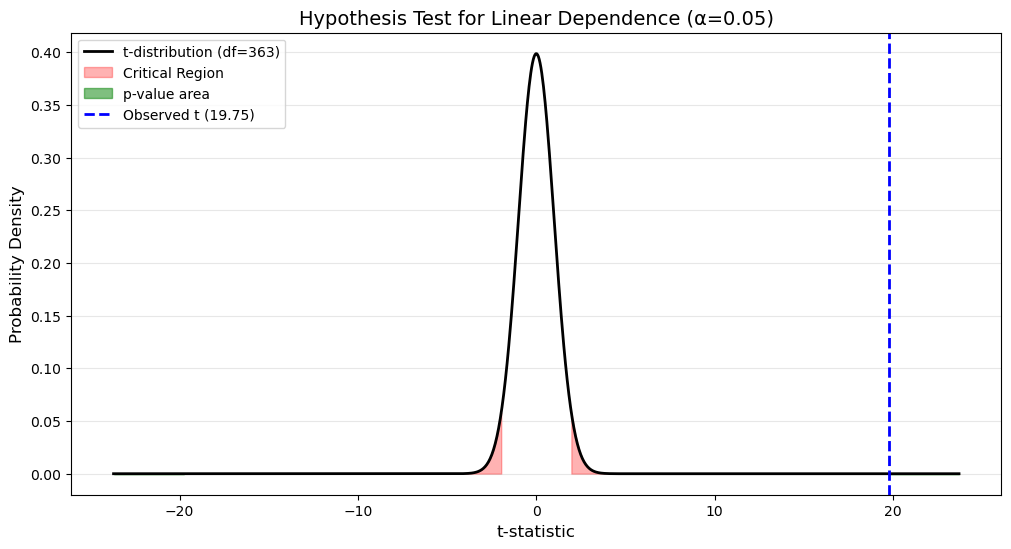

In [20]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. Calculate Pearson Correlation (r) and p-value
n = len(df)
r, p_val = stats.pearsonr(df['Temp_Max'], df['Solar_Radiation'])
df_deg = n - 2

# 2. Calculate the observed t-statistic
# t = r * sqrt((n-2)/(1-r^2))
t_stat = r * np.sqrt(df_deg / (1 - r**2))

# 3. Define the critical t-value for alpha = 0.05 (two-tailed)
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df_deg)

print(f"Sample size (n): {n}")
print(f"Pearson Correlation (r): {r:.4f}")
print(f"Observed t-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")
print(f"Critical t-value: {t_crit:.4f}")

# --- 4. Plotting the Theoretical PDF and Regions ---
x = np.linspace(-5, 5, 1000) # Range for the t-distribution plot
# Note: If t_stat is very large, we adjust the x-range to see it
if abs(t_stat) > 5:
    x = np.linspace(-abs(t_stat)*1.2, abs(t_stat)*1.2, 1000)

y = stats.t.pdf(x, df_deg)

plt.figure(figsize=(12, 6))
plt.plot(x, y, label=f't-distribution (df={df_deg})', color='black', lw=2)

# Shade Critical Regions (alpha/2 in each tail)
x_crit_left = np.linspace(min(x), -t_crit, 100)
x_crit_right = np.linspace(t_crit, max(x), 100)
plt.fill_between(x_crit_left, stats.t.pdf(x_crit_left, df_deg), color='red', alpha=0.3, label='Critical Region')
plt.fill_between(x_crit_right, stats.t.pdf(x_crit_right, df_deg), color='red', alpha=0.3)

# Shade P-value Area (Area beyond |t_stat|)
x_p_left = np.linspace(min(x), -abs(t_stat), 100)
x_p_right = np.linspace(abs(t_stat), max(x), 100)
plt.fill_between(x_p_left, stats.t.pdf(x_p_left, df_deg), color='green', alpha=0.5, label='p-value area')
plt.fill_between(x_p_right, stats.t.pdf(x_p_right, df_deg), color='green', alpha=0.5)

# Mark the observed t-statistic
plt.axvline(t_stat, color='blue', linestyle='--', lw=2, label=f'Observed t ({t_stat:.2f})')

plt.title(f'Hypothesis Test for Linear Dependence (α={alpha})', fontsize=14)
plt.xlabel('t-statistic', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

Task 4:


Linear Regression Model

Since the hypothesis test in Task 3 provided evidence of linear dependence, we model the relationship between temperature (X) and solar radiation (Y) using the Ordinary Least Squares (OLS) model Y=aX+b+ε,

where (\varepsilon) represents the residual noise. The regression coefficients are estimated using OLS, and the residuals are analysed to assess the normality assumption.




In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df['Temp_Max'], df['Solar_Radiation']
)

# Predicted values and residuals
df['Y_pred'] = intercept + slope * df['Temp_Max']
df['residuals'] = df['Solar_Radiation'] - df['Y_pred']

# Sample standard deviation of residuals
s_res = np.std(df['residuals'], ddof=1)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Residual standard deviation s: {s_res:.4f}")


Slope: 0.8836
Intercept: -2.5798
Residual standard deviation s: 5.3371


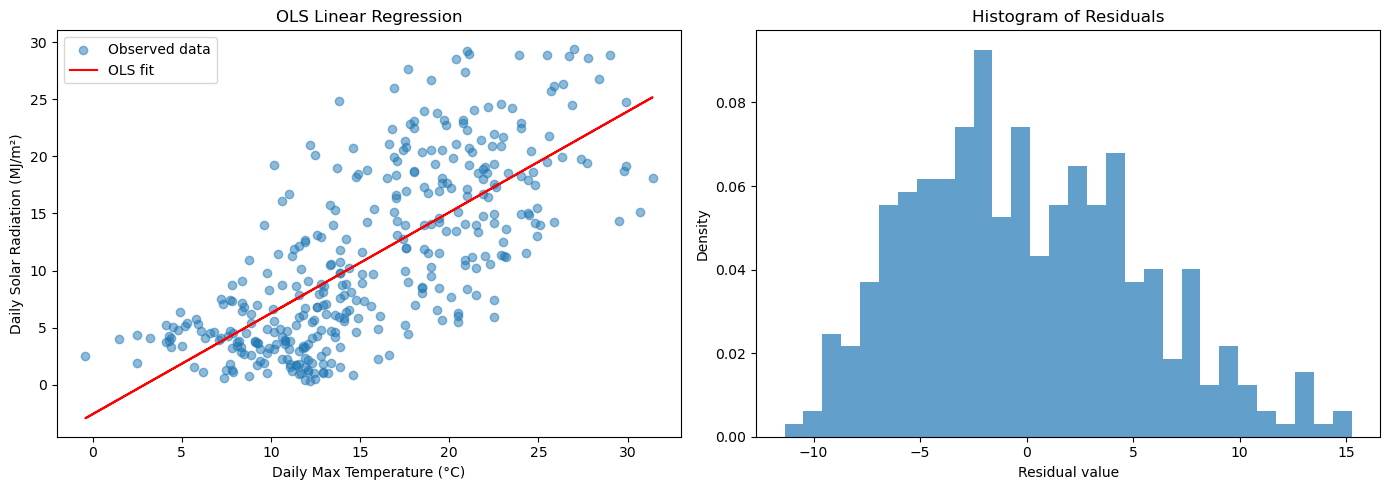

In [22]:
plt.figure(figsize=(14, 5))

# Scatter plot with regression line
plt.subplot(1, 2, 1)
plt.scatter(df['Temp_Max'], df['Solar_Radiation'], alpha=0.5, label='Observed data')
plt.plot(df['Temp_Max'], df['Y_pred'], color='red', label='OLS fit')
plt.xlabel('Daily Max Temperature (°C)')
plt.ylabel('Daily Solar Radiation (MJ/m²)')
plt.title('OLS Linear Regression')
plt.legend()

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(df['residuals'], bins=30, density=True, alpha=0.7)
plt.xlabel('Residual value')
plt.ylabel('Density')
plt.title('Histogram of Residuals')

plt.tight_layout()
plt.show()



Kolmogorov–Smirnov Test for Normality of Residuals
To test whether the residuals could plausibly come from a normal distribution, we perform a Kolmogorov–Smirnov (KS) test at significance level α=0.05.

Hypotheses
H0:ε∼N(0,s^2),

H1:ε≁N(0,s^2),


where s is the sample standard deviation of the residuals.


In [23]:
from scipy.stats import kstwobign

# KS statistic (unscaled)
Dn, _ = stats.kstest(df['residuals'], 'norm', args=(0, s_res))

# Scaled KS statistic
n = len(df)
K = np.sqrt(n) * Dn

# Critical value and p-value
alpha = 0.05
K_crit = kstwobign.ppf(1 - alpha)
p_value_K = kstwobign.sf(K)

print(f"KS statistic D_n: {Dn:.4f}")
print(f"Scaled KS statistic K: {K:.4f}")
print(f"Critical value (alpha=0.05): {K_crit:.4f}")
print(f"P-value: {p_value_K:.4f}")


KS statistic D_n: 0.0648
Scaled KS statistic K: 1.2377
Critical value (alpha=0.05): 1.3581
P-value: 0.0934


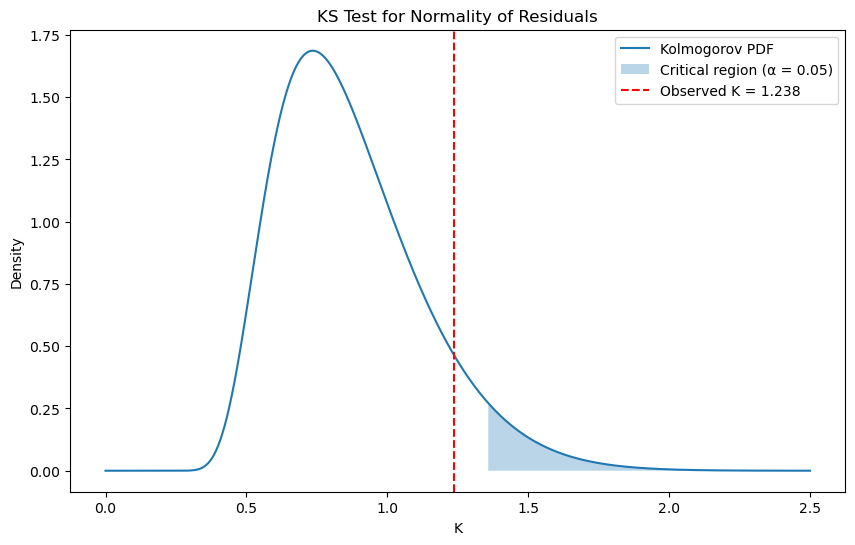

In [24]:
x = np.linspace(0, 2.5, 1000)
y = kstwobign.pdf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Kolmogorov PDF')

# Critical region
x_crit = np.linspace(K_crit, 2.5, 200)
plt.fill_between(x_crit, kstwobign.pdf(x_crit), alpha=0.3, label='Critical region (α = 0.05)')

# Observed statistic
plt.axvline(K, color='red', linestyle='--', label=f'Observed K = {K:.3f}')

plt.xlabel('K')
plt.ylabel('Density')
plt.title('KS Test for Normality of Residuals')
plt.legend()
plt.show()



Conclusion
Since the p-value exceeds the significance level α=0.05 and the observed test statistic does not fall within the critical region, we fail to reject the null hypothesis.

In context, this suggests that once the linear dependence of solar radiation on temperature is removed, the remaining variability can plausibly be modelled as Gaussian noise with mean zero and variance s^2. This supports the assumptions underlying the linear regression model.

Task 5: Testing Independence via Marginals

From the course material, two random variables X and Y are independent if and only if their joint distribution factorises as the product of their marginal distributions. That is, independence holds if PX,Y =PX ⊗PY.

A natural way to test this property empirically is to compare the empirical joint distribution of (X,Y) with the product of the empirical marginals. For our continuous weather data, a robust "thought experiment" for this test would be:
1.   Discretization: Partition the range of X (Temperature) and Y (Solar Radiation) into k non-overlapping bins, creating a 2D grid of cells.
2.   Estimation: Calculate the marginal probabilities P(X∈bini ) and P(Y∈binj ) by counting occurrences in each row and column.
3.   Product Construction: Under the null hypothesis of independence, the expected probability for each cell (i,j) in the grid is simply the product of the marginals: Ei,j =P(Xi )⋅P(Yj )⋅n.
4.   Discrepancy Measure: Use a Pearson Chi-squared test to compare the observed counts Oi,j  in the joint grid against the expected counts Ei,j.

If the calculated χ2 statistic is significantly large, we reject the null hypothesis of independence. This approach directly operationalizes the definition of the product distribution by testing whether the "shared randomness" we observed in Task 3 is strong enough to violate the factorization property PX,Y =PX ⊗PY .


